###  피마 인디언 당뇨병 여부 예측
- 이진 분류 예측 모델
- 사용할 알고리즘 : LogisticRegression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# 이진분류예측 모델: LogisticRegression 사용
from sklearn.linear_model import LogisticRegression

# 데이터 정규화(표준화)
from sklearn.preprocessing import StandardScaler

# 학습데이터, 테스트데이터 분리
from sklearn.model_selection import train_test_split

# 성능 평가
from sklearn.metrics import accuracy_score  # 정확도
from sklearn.metrics import confusion_matrix  # 오차행렬
from sklearn.metrics import precision_score, recall_score, precision_recall_curve  # 정밀도, 재현율, 정밀도-재현율 커브
from sklearn.metrics import f1_score # F1 score(정밀도, 재현율 조화평균 지표)
from sklearn.metrics import roc_curve, roc_auc_score # ROC curve와 AUC 점수(0.5 <= ROC 커브아래 면적값 <=1)

In [5]:
# 데이터 로딩(피마인디언 당뇨병 데이터)
d_data  = pd.read_csv(
    './data/diabetes.csv'
)

In [6]:
d_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [7]:
# 당뇨병 분포 확인(정답 확인)
# Negative(0)수치가 많이 높다 => 불균형 데이터셋 (정확도, 정밀도, 재현율 모두 고려해야 함)
d_data['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

- Glucose 컬럼 :  값의 크기차이가 크다(즉 분산이 크다) => 표준화 필요

In [8]:
# 결측치 확인
# 데이터 타입 확인 : object(string)있으면 =>encoding 필요(숫자로 변환 작업)
d_data.info()
# 결측치 : 현재 Null 값이 없으므로 skip
# object type 없으므로 encoding 필요X

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


#### Row 단위접근으로 데이터, 답 분리하는 방법
- df에서 row 단위접근은 iloc나 loc를 써야한다.
- 숫자 index로 접근하는 iloc가 명index접근인 loc 보다 속도가 더 빠르다.

#### 데이터프레임에서는 컬럼단위의 접근 방법이 basic 이다.

In [29]:
# 데이터와 답을 분리
# iloc[행, 열] : 숫자 인덱스로 행접근
# loc[행, 열] : 명인덱스로 행접근
X = d_data.iloc[:,:-1]  # 답을 제외한 데이터만 추출
y = d_data.iloc[:,-1]   # 답 추출

In [24]:
X.iloc[:3,:] # 3행, 모든 컬럼 가져오기

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32


In [28]:
# 정확도, 오차행렬, 정밀도, 재현율, f1점수, auc 점수 함수
def get_clf_aval(y_test=None, pred=None):
    '''
    y_test : 원래답
    pred: 예측값(생성한 모델로 피팅한 예측값)
    '''
    # 오차행렬 구하기
    confusion = confusion_matrix(y_test, pred)
    # 정확도 구하기
    accu = accuracy_score(y_test, pred)
    # 정밀도 구하기
    precision = precision_score(y_test, pred)
    # 재현율 구하기
    recall = recall_score(y_test, pred)
    # F1 스코어(정밀도, 재현율 조화평균)
    f1 = f1_score(y_test, pred)
    # AUC 스코어 : 중요한 성능평가 지표
    roc_auc = roc_auc_score(y_test, pred)
    
    print('오차행렬')
    print(confusion)
    # 성능평가 지표들
    output = '정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율:{2:.4f}, F1스코어: {3:.4f}, AUC 점수:{4:.4f}'
    print(output.format(accu, precision, recall, f1, roc_auc))

In [65]:
# 임계값 확인 시각화 함수
# parameter : 원래값, 예측값 확률
def precision_recall_curve_plot(y_test=None, pred_proba_p=None):
    # 정밀도, 재현율, 임계값 튜플로 반환 함수
    precisions, recalls, ths = \
    precision_recall_curve(y_test, pred_proba_p)
    
    # 시각화하기
    # x축: 임계값, y축: 정밀도, 재현율
    plt.figure(figsize=(6,4))
    ths_boundary = ths.shape[0]
    plt.plot(ths, precisions[0:ths_boundary], linestyle='--', label = 'precision')
    plt.plot(ths, recalls[0:ths_boundary], label='recall')
    
    # x축 스케일 조정 => 원래 스케일 : 0.2 단위 => 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(
        np.round(
            np.arange(start, end, 0.1), 1 # 반올림 위치지정
        )
    )
    plt.legend()
    plt.grid()
    plt.show()
    

In [72]:
# 학습데이터, 테스트 데이터 분리 
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [74]:
# LogisticRegression (분류모델) 객체 생성
lr_clf = LogisticRegression()  # 하이퍼 파라미터를 주지 않고 생성 => default 처리됨

# 학습
lr_clf.fit(X_train, y_train)
# 예측
pred = lr_clf.predict(X_test)
# 성능 평가
get_clf_aval(y_test, pred)

오차행렬
[[91  8]
 [21 34]]
정확도: 0.8117, 정밀도: 0.8095, 재현율:0.6182, F1스코어: 0.7010, AUC 점수:0.7687


C:\Users\TJ\anaconda3\envs\ml01-02\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [62]:
len(y_test) # 데스트데이터 개수

154

In [63]:
lr_clf?

In [64]:
# 1차 성능평가 결과
# 정확도: 0.8117, 정밀도: 0.8095, 재현율:0.6182, F1스코어: 0.7010, AUC 점수:0.7687

# 성능 향상 시키기
# 1. 알고리즘(LogisticRegression) 튜닝 : 하이퍼파라미터 조절
# 2. 데이터 전처리
# 3. 알고리즘 변경

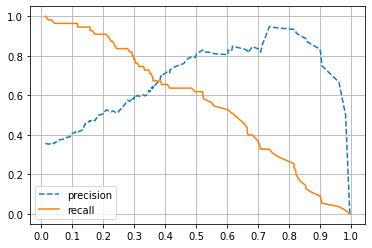

In [75]:
# 시각화 함수 => def precision_recall_curve_plot(y_test=None, pred_proba_p=None)
# y_test: 원래답, pred_proba_p : 예측값이 1 이나올 확률
# 예측확률 함수로 pred_proba_p 구하기 : lr_clf.predict_proba() => 답 클래스 각각의 확률을 반환
pred_proba_v = lr_clf.predict_proba(X_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba_v)

1. 데이터 전처리 하기

In [76]:
d_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <a list of 10 Patch objects>)

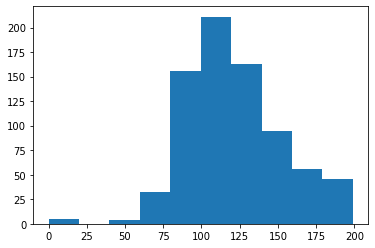

In [79]:
# 포도당(Glucose) : 데이터 분포 시각화,히스토그램
plt.hist(
    d_data['Glucose'] # 데이터
    , bins = 10 # 분리할 개수
)

In [80]:
d_data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [91]:
# 컬럼별 0 값 비율 확인
# 0 개수 / 전체 개수
zero_features = [
    'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI'
]
# 전체 데이터 개수
total_count = d_data['Glucose'].count()

# 컬럼별 0의 비율 출력
for feature in zero_features:
    # 컬럼별 0의 개수
    zero_count = d_data[d_data[feature]==0][feature].count()
    output_str = '{0} 컬럼의 0의 개수: {1}, 비율 {2:.2f} % '
    print(output_str.format(feature, zero_count, zero_count/total_count*100))

Glucose 컬럼의 0의 개수: 0, 비율 0.00 % 
BloodPressure 컬럼의 0의 개수: 0, 비율 0.00 % 
SkinThickness 컬럼의 0의 개수: 0, 비율 0.00 % 
Insulin 컬럼의 0의 개수: 0, 비율 0.00 % 
BMI 컬럼의 0의 개수: 0, 비율 0.00 % 


- 0이 아니어야 정상인 값들이 꽤 많은 0 값을 가지고 있다 => 데이터 수집이 잘못된 경우 (비정상적인 데이터)
- 학습결과가 정확하지 않을 것이다

In [88]:
# 각 컬럼의 0 값을 각 컬럼의 평균으로 대체(replace)하기
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI']
# 각 컬럼의 평균값 저장하는 변수 선언
mean_zero_features = d_data[zero_features].mean()
mean_zero_features

Glucose          120.894531
BloodPressure     69.105469
SkinThickness     20.536458
Insulin           79.799479
BMI               31.992578
dtype: float64

In [90]:
# 각 컬럼의 0 값을 각 컬럼의 평균으로 대체(replace)하기
# replace(원래값, 변경값 시리즈) => 컬럼 브로드캐스팅 가능
d_data[zero_features] = d_data[zero_features].replace(0, mean_zero_features)

In [94]:
# 비이상치값을 변경한 후 다시 정규화, 학습, 평가
X = d_data.iloc[:, :-1]  # 데이터
y = d_data.iloc[:, -1]  # 답

In [95]:
# 정규화: StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [96]:
# 학습데이터, 테스트 데이터 분리
X_train,X_test, y_train,y_test = train_test_split(X_scaled, y, test_size=0.2, random_state =12)

In [105]:
# 모델객체 생성 후 학습
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
# 예측결과
pred = lr_clf.predict(X_test)
# 성능평가
get_clf_aval(y_test, pred)

오차행렬
[[90  9]
 [20 35]]
정확도: 0.8117, 정밀도: 0.7955, 재현율:0.6364, F1스코어: 0.7071, AUC 점수:0.7727


- 여전히 underfitting 상황(AUC 가 0.8 이하임)
- 큰 성능의 향상이 있지는 않다. 0값을 평균치 처리하는 것이 큰 의미가 없었다
- 전처리를 하더라도 정밀하게 하지 않으면 오히려 성능이 떨어질수 있다.

- 우선 overfitting 되도록 하고, 나중에 조정하는 식으로 해야함.

- 임계값 조절해보기